In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from pathlib import Path
from skimage.color import rgb2gray
from skimage import io, exposure, filters
import glob

myBreeds = [
    "n02099712-Labrador_retriever",
    "n02110185-Siberian_husky",
    "n02113799-standard_poodle",
    "n02113186-Cardigan"
]

class AllRequiredPaths:
    root_dir = ""
    imgs_folder = ""
    imgs_folder_sub_folders = [f"images/{name}" for name in myBreeds]

    def __init__(self):
        self.root_dir = os.getcwd()
        self.imgs_folder = os.path.join(self.root_dir, "images")


all_paths = AllRequiredPaths()

# 1. Get all the image of four classes
breeds_images = [str(image_path) for breed_path in all_paths.imgs_folder_sub_folders for image_path in Path(os.path.join(all_paths.root_dir, breed_path)).glob("*.jpg")]
breeds_labels = [ i for i, breed_path in enumerate(all_paths.imgs_folder_sub_folders) for _ in Path(os.path.join(all_paths.root_dir, breed_path)).glob("*.jpg")]

In [2]:
#2. Convert the images to edge histograms.
class EdgeHistogramAnalysis:
    def __init__(self, all_images):
        self.all_paths = AllRequiredPaths()
        self.all_images = all_images
        
    def _angle(self, dx, dy):
        return np.mod(np.arctan2(dy, dx), np.pi)

    def show_result(self):
        histograms = []
        for image_path in self.all_images:
            img = io.imread(image_path)
            grayscale_img = rgb2gray(img)
            dx = filters.sobel_h(grayscale_img)
            dy = filters.sobel_v(grayscale_img)
            ang = self._angle(dx, dy)
            hist, _ = exposure.histogram(ang, nbins=36, source_range='dtype')
            histograms.append(hist)
            
        return np.array(histograms)
            
            

edge_hist_analysis = EdgeHistogramAnalysis(breeds_images)
histograms = edge_hist_analysis.show_result()
print(histograms)

[[   0    0    0 ... 3111 3253 3169]
 [   0    0    0 ... 3791 3902 3861]
 [   0    0    0 ... 3009 3106 3246]
 ...
 [   0    0    0 ... 1501 1859 2281]
 [   0    0    0 ... 1590 1851 2300]
 [   0    0    0 ... 2115 2209 2187]]


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#3. Split the dataset into a training set and a test set: For each class, perform a training/test split of 80/20. (0.25 point) 
train_X, test_X, train_y, test_y = train_test_split(histograms, breeds_labels, test_size=0.2, stratify=breeds_labels)

In [4]:
#4. Perform standardization on the training dataset. (see https://scikit-learn.org/stable/modules/preprocessing.html (0.25 point)

standard_scaler = StandardScaler().fit(train_X)
Xt_standardized = standard_scaler.transform(train_X)
Xt_standardized

array([[ 0.        ,  0.        ,  0.        , ...,  0.43566152,
         0.57392675,  0.71469225],
       [ 0.        ,  0.        ,  0.        , ..., -0.91066369,
        -0.84831186, -0.81780824],
       [ 0.        ,  0.        ,  0.        , ..., -0.42822353,
        -0.39536963, -0.36504225],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.11104834,
        -0.02807466, -0.04312884],
       [ 0.        ,  0.        ,  0.        , ..., -0.26295857,
        -0.24795752, -0.1234065 ],
       [ 0.        ,  0.        ,  0.        , ..., -1.01165895,
        -1.02290051, -0.89888867]])

In [5]:
#5. Perform standardization on the test dataset using the means and variances you obtained from the training dataset.
Xtest_standardized = standard_scaler.transform(test_X)
Xtest_standardized

array([[ 0.        ,  0.        ,  0.        , ..., -0.43323156,
        -0.52878171, -0.57777804],
       [ 0.        ,  0.        ,  0.        , ..., -0.10604032,
        -0.20348683, -0.32972008],
       [ 0.        ,  0.        ,  0.        , ...,  0.09428086,
        -0.15078082, -0.21090914],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -1.01332829,
        -1.00972401, -0.96230802],
       [ 0.        ,  0.        ,  0.        , ..., -0.1886728 ,
        -0.19525152, -0.12982871],
       [ 0.        ,  0.        ,  0.        , ...,  0.67437759,
         0.77404486,  0.71148115]])

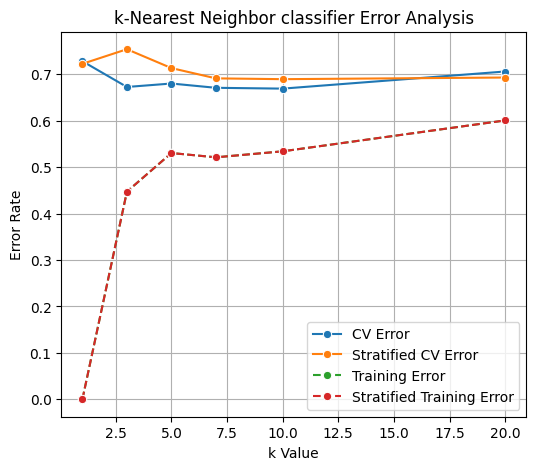

Lowest k value for startified CV error is 10
Test data set error k = KNeighborsClassifier(n_neighbors=10) : 74.26%


In [16]:
#6. (Model Selection) Perform a standard 5-fold cross-validation and a stratified 5-fold cross-validation
# on the training set (i.e., the standardized edge histogram dataset obtained from the training set) for
# k-Nearest Neighbor Classifiers such that 𝑘 = 1, 3, 5, 7, 6, 20. (2.5 points)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

def plot_graph_using_seaborn(train_x_std, train_y,train_X ,test_x_std, test_y):
    k_data = [1, 3, 5, 7, 10, 20]
    errors = []
    scv_errors = []
    training_errors = []
    st_errors = []

    sf = StratifiedKFold(n_splits=5)

    for val in k_data:
        knn = KNeighborsClassifier(n_neighbors=val)

        ccv_scores = cross_val_score(knn, train_x_std, train_y, cv = 5)
        errors.append(np.mean(1 - ccv_scores))

        st_cv_scores = cross_val_score(knn, train_X, train_y, cv=sf)
        scv_errors.append(np.mean(1 - st_cv_scores))

        knn.fit(train_X, train_y)
        training_errors.append(1 - knn.score(train_X, train_y))
        st_errors.append(training_errors[-1])


    plt.figure(figsize=(6, 5))
    sns.lineplot(x=k_data, y=errors, marker='o', label='CV Error')
    sns.lineplot(x=k_data, y=scv_errors, marker='o', label='Stratified CV Error')
    sns.lineplot(x=k_data, y=training_errors, marker='o', linestyle='--', label='Training Error')
    sns.lineplot(x=k_data, y=st_errors, marker='o', linestyle='--', label='Stratified Training Error')

    plt.xlabel('k Value')
    plt.ylabel('Error Rate')
    plt.title('k-Nearest Neighbor classifier Error Analysis')
    plt.legend()
    plt.grid(True)
    plt.show()

    kval = k_data[np.argmin(scv_errors)]
    print(f"Lowest k value for startified CV error is {kval}")

    # test dataset error with k
    knn_val = KNeighborsClassifier(n_neighbors = kval)
    knn_val.fit(train_x_std, train_y)
    test_error = 1 - knn_val.score(test_x_std, test_y)
    print(f"Test data set error k = {knn_val} : {test_error * 100:.2f}%")

plot_graph_using_seaborn(Xt_standardized, train_y, train_X ,Xtest_standardized, test_y)


In [19]:
# • Plot a graph (x-axis: k; y-axis: mean validation/training error (%)) containing four error curves
# (2 validation error curves and 2 training error curves - label them clearly using a legend to
# define the curves). Which 𝑘 has the lowest mean error for each curve? Comment about (1) the
# model complexity for k-Nearest Neighbor classifier in relation to 𝑘, and (2) when/whether there is
# overfitting/underfitting. (1.5 points)

# Ans:=========================================================>>>>>>>>>>>
 # lowest mean error for each curve at,
      # + CV Error: k = 10
      # + stratified CV Error: k = 10
      # + training Error: k = 1
      # + stratified training error: k = 1

# comments on 1 and 2
# 1. As k values increases the complexity of the model drecrease which makes this method best.
# 2. Overfitting main happens due to low value of k which makes the model more complex.
#    Similarly underfitting happens due to high value of k which increases the error rate of training and validation error.

In [20]:
# • Use the 𝑘 value with the lowest mean validation error for your k-Nearest Neighbor classifier from
# the stratified 5-fold cross-validation. What is the error for the test dataset (i.e., the standardized
# edge histogram dataset obtained from the test set)? (0.25 point)

# Ans: Test error rate of dataset is : 74.26%

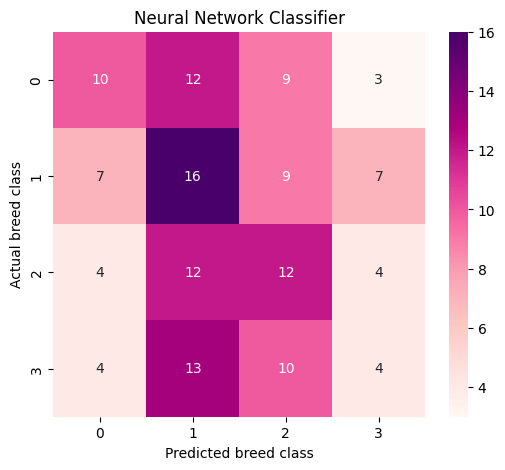

Model Accuracy score: 0.31  | F1 Score: 0.30
Mean cross-validation scroe: 0.30


In [41]:
# 7. Performance Comparison) Perform stratified 5-fold cross-validation on the 4-class classification problem
# using the three classification methods (available on canvas) assigned to you. 
# Plot the (3) confusion matrices for using three approaches (clearly label the classes 
# on the test set (See Figure 1). (If you use code from any website, please do proper 
# referencing. You will get 0 point for this assignment without proper referencing) 
# (3.75 points)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import random


class PlotGraph:
    def __init__(self, classifier):
        self.classifier = classifier

    def show_graph(self, title, Xtest_standardized, test_y, cv_scores):
        pred = self.classifier.predict(Xtest_standardized)
        _confusion_matrix = confusion_matrix(test_y, pred)

        cmaps = ["YlOrBr", "YlOrRd", "OrRd", "PuRd", "RdPu", "BuPu"]
        cmap = random.choice(cmaps)

        plt.figure(figsize=(6,5))
        cm_plot = sns.heatmap(_confusion_matrix, annot = True, fmt = "d", cmap = cmap)
        cm_plot.set_title(title)
        cm_plot.set_xlabel("Predicted breed class")
        cm_plot.set_ylabel("Actual breed class")
        plt.show()

        _acc = accuracy_score(test_y, pred)
        f1Scroe = f1_score(test_y, pred, average="weighted")

        print(f"Model Accuracy score: {_acc:.2f}  | F1 Score: {f1Scroe:.2f}")
        print(f"Mean cross-validation scroe: {np.mean(cv_scores):.2f}")
        
        


# Neural Network :  MLP classifier
clf = MLPClassifier(random_state=1, max_iter=300, learning_rate_init=0.01).fit(train_X, train_y)
strat_fold = StratifiedKFold(n_splits=5)

_cross_val_scores = cross_val_score(clf, Xt_standardized, train_y, cv = strat_fold)
clf.fit(Xt_standardized, train_y)

plotter = PlotGraph(clf)
plotter.show_graph("Neural Network Classifier", Xtest_standardized, test_y, _cross_val_scores)

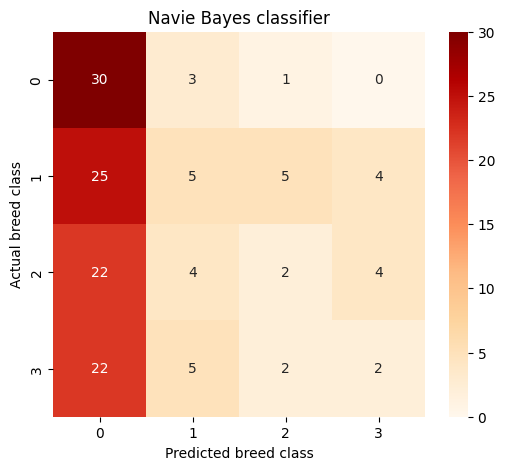

Model Accuracy score: 0.29  | F1 Score: 0.21
Mean cross-validation scroe: 0.28


In [44]:
# Navie Bayes classifier
from sklearn.naive_bayes import GaussianNB

gaussianNB_classifier = GaussianNB()
strat_fold = StratifiedKFold(n_splits=5)
_cross_val_scores = cross_val_score(gaussianNB_classifier, Xt_standardized, train_y, cv = strat_fold)
gaussianNB_classifier.fit(Xt_standardized, train_y)

plotter = PlotGraph(gaussianNB_classifier)
plotter.show_graph("Navie Bayes classifier", Xtest_standardized, test_y, _cross_val_scores)

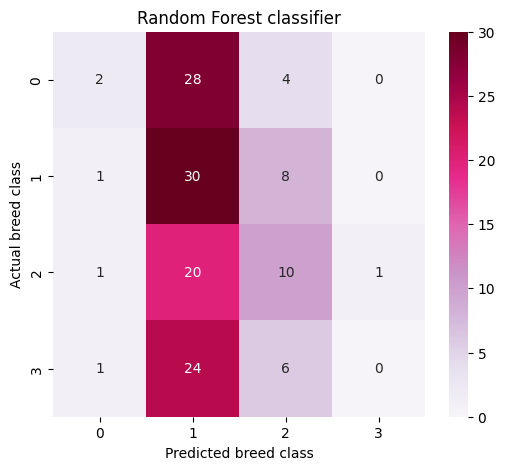

Model Accuracy score: 0.31  | F1 Score: 0.23
Mean cross-validation scroe: 0.30


In [45]:
# Random forest classifier
from sklearn.ensemble import RandomForestClassifier

rand_fcls = RandomForestClassifier(max_depth=2, random_state=1)
strat_fold = StratifiedKFold(n_splits=5)
_cross_val_scores = cross_val_score(rand_fcls, Xt_standardized, train_y, cv = strat_fold)
rand_fcls.fit(Xt_standardized, train_y)

plotter = PlotGraph(rand_fcls)
plotter.show_graph("Random Forest classifier", Xtest_standardized, test_y, _cross_val_scores)

In [46]:
# By visually comparing (e.g., looking at the color on the diagonal values, etc.) the 
# three matrices (on the test set), which do you think is the best method? Why? (0.50 point)

# Ans: Neural network is the best method as its total of diagonal values is more compare to other two methods

In [47]:
# Based on the mean validation accuracies (from the 5-fold cross-validation) 
# for the three methods. Which is the best method? (0.25 point)

# Ans: Both Neural network and random forest has same mean cross validation score: 0.30

In [49]:
# Compute the accuracies for the three methods 
# on the test set. Which is the best method? (0.25 point)

# Ans: Neural network and Random forest has accuracies: 0.31.

In [51]:
# Compute the F-measure for the three methods on the test set.
# Which is the best method? (0.25 point)

# Ans: Neural network has the best F1-score value: 0.30. so it is best

In [53]:
# References:
# https://scikit-learn.org/stable/modules/naive_bayes.html
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix